### LSUN Bedroom Generator

In [92]:
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import default_collate

import numpy as np

from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
from torch.utils.data import DataLoader

import fastcore.all as fc
from fastprogress import progress_bar

from diffusers import AutoencoderKL, UNet2DModel
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.models.resnet import ResnetBlock2D

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

import matplotlib.pyplot as plt

In [93]:
from pathlib import Path
import shutil
from glob import glob
from functools import partial
from itertools import islice

from miniai.init import clean_mem
from miniai.datasets import show_image, show_images
from miniai.learner import to_cpu, Learner, Callback, DeviceCB, ProgressCB, MetricsCB
from miniai.diffusion2 import noisify
from miniai.sgd import BatchSchedCB
from miniai.accel import MixedPrecision
from miniai.training import get_dls
from miniai.datasets import DataLoaders
from miniai.fid import ImageEval
from miniai.activations import ActivationStatsMod, set_seed

### ----------------------------------------

### Hyperparameter

In [94]:
bs = 32

lr = 1e-3
epochs = 5
adam_eps = 1e-5

### Device

In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Config

In [96]:
figsize_img = (2, 2)
figsize_stats = (10, 2)
figsize_cld = (10, 2)
figsize_cldz = (10, 1)
figsize_dead = (10, 4)

### ----------------------------------------

### Data

#### Data origin

In [97]:
path_data = Path("data/")
path_data.mkdir(exist_ok= True)
path_bedroom = path_data/"bedroom/"
path_bedroom

Path('data/bedroom')

In [98]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path_bedroom.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive("data/bedroom.tgz", "data")

#### ----------

#### Data subbing

In [99]:
n_imgs = 10000
path_sub = path_data/f"bedroom_{n_imgs}"
path_sub

Path('data/bedroom_10000')

In [100]:
%%time

if not path_sub.exists():
    path_sub.mkdir()

    img_paths = glob(str(path_bedroom/f"**/*.jpg"), recursive= True)
    scr_img_paths = img_paths[:n_imgs]
    dest_img_paths = [path_sub/Path(x).name for x in scr_img_paths]

    [shutil.copy(scr, dest) for scr, dest in zip(scr_img_paths, dest_img_paths)]

CPU times: total: 0 ns
Wall time: 0 ns


### ----------------------------------------

### Data Processing

#### Data class

In [101]:
def to_tensor(img): return read_image(img, mode= ImageReadMode.RGB)/255

In [102]:
class ImagesDS():

    def __init__(self, path, spec= ".jpg"):

        self.path = Path(path)
        self.files = glob(str(path/f"**/*{spec}"), recursive= True)

    def __len__(self): return len(self.files)
    def __getitem__(self, i): return to_tensor(self.files[i]), self.files[i]
    def __repr__(self): return f"{len(self.files)} items"
        

In [103]:
dts = ImagesDS(path_sub)
dts, dts[0][0].shape, dts[0][1]

(10000 items,
 torch.Size([3, 256, 341]),
 'data\\bedroom_10000\\000038527b455eaccd15e623f2e229ecdbceba2b.jpg')

#### ----------

#### Mean | Std | Original

In [104]:
imgs_mean = 0.5178
imgs_std = 0.2395

#### ----------

#### Visualize Image

In [105]:
def show_image_mod(image, figsize= figsize_img, clamp= True):

    if clamp: image = image.clamp(0, 1)
    show_image(image, figsize= figsize)

def show_images_mod(images, imsize= 1., clamp= True):

    if clamp: images = images.clamp(0, 1)
    show_images(images, imsize= imsize)

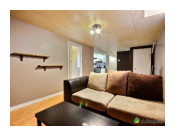

In [106]:
show_image_mod(dts[0][0])

#### ----------

#### Transforms

In [107]:
tfmx = transforms.Compose(
    [
        transforms.Resize((256, 256), antialias= True)])

In [17]:
class ImagesDSTfm():

    def __init__(self, dts, tfmx= fc.noop, tfmy= fc.noop): fc.store_attr()
    def __len__(self): return len(self.dts)
    def __getitem__(self, i): return self.tfmx(self.dts[i][0]), self.tfmy(self.dts[i][1])
    def __repr__(self): return f"{self.dts} with transforms"

In [109]:
dts_tfm = ImagesDSTfm(dts, tfmx= tfmx)
dts_tfm, dts_tfm[0][0].shape, dts_tfm[0][1]

(10000 items with transforms,
 torch.Size([3, 256, 256]),
 'data\\bedroom_10000\\000038527b455eaccd15e623f2e229ecdbceba2b.jpg')

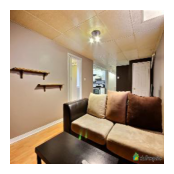

In [110]:
show_image_mod(dts_tfm[0][0])

#### ----------

#### Mean | Std | Transforms

In [111]:
#NoNorm
imgs_tfm_mean = 0.5178
imgs_tfm_std = 0.2371

### ----------------------------------------

### DataLoader

In [112]:
dls = DataLoader(dts_tfm, batch_size= bs, shuffle= True)
xb, yb = next(iter(dls))
xb.shape

torch.Size([32, 3, 256, 256])

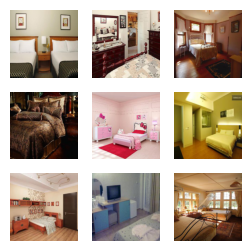

In [113]:
show_images_mod(xb[:9])

### ----------------------------------------

### VAE

In [114]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").requires_grad_(False).to(device)

#### Latents

In [115]:
path_ltt = path_data/f"bedroom_{n_imgs}_latents_nonorm/"
path_ltt

Path('data/bedroom_10000_latents_nonorm')

In [116]:
if not path_ltt.exists():
    path_ltt.mkdir()

    for imgs, paths in progress_bar(dls):

        ltts = vae.encode(imgs.to(device))
        ltts_m_np = to_cpu(ltts.latent_dist.mean).numpy()

        [np.save(path_ltt/Path(p).with_suffix(".npy").name, ltt)
         for p, ltt in zip(paths, ltts_m_np)]

### ----------------------------------------

### Data Splitting

In [117]:
path_trn = Path(f"{path_ltt}_train/")
path_val = Path(f"{path_ltt}_valid/")
path_trn, path_val

(Path('data/bedroom_10000_latents_nonorm_train'),
 Path('data/bedroom_10000_latents_nonorm_valid'))

In [118]:
split_portion = 0.1
n_trn = int(n_imgs * (1-split_portion))
n_trn

9000

In [119]:
%%time

if not path_trn.exists() or not path_val.exists():
    path_trn.mkdir()
    path_val.mkdir()

    ltt_files = glob(f"{path_ltt}/**/*.npy", recursive= True)
    ltt_files_trn = ltt_files[:n_trn]
    ltt_files_val = ltt_files[n_trn:]

    [shutil.copy(p, path_trn/Path(p).name) for p in ltt_files_trn]
    [shutil.copy(p, path_val/Path(p).name) for p in ltt_files_val]

CPU times: total: 0 ns
Wall time: 0 ns


### ----------------------------------------

### Latents Dataset

#### Data Class

In [120]:
class NumpyDS(ImagesDS):

    def __getitem__(self, i): return torch.from_numpy(np.load(self.files[i])), self.files[i]

In [121]:
dts_trn = NumpyDS(path_trn, spec= ".npy")
dts_trn, dts_trn[0][0].shape, dts_trn[0][1]

(9000 items,
 torch.Size([4, 32, 32]),
 'data\\bedroom_10000_latents_nonorm_train\\000038527b455eaccd15e623f2e229ecdbceba2b.npy')

In [122]:
dts_val = NumpyDS(path_val, spec= ".npy")
dts_val, dts_val[0][0].shape, dts_val[0][1]

(1000 items,
 torch.Size([4, 32, 32]),
 'data\\bedroom_10000_latents_nonorm_valid\\073bf236c811160148e09bb29b1409f649add958.npy')

#### ----------

#### Mean | Std | Latents

In [123]:
#NoNorm
ltts_mean = 1.7197
ltts_std = 4.8114

#### ----------

#### Dataloader

In [124]:
set_seed(42)

In [125]:
def collate_ddpm(b): return noisify(default_collate(b)[0]*0.2)

In [126]:
dls = DataLoaders(*get_dls(dts_trn, dts_val, bs= bs, collate_fn= collate_ddpm))

### ----------------------------------------

### Training

In [127]:
class TrainLearner(Learner):

    def predict(self): self.preds = self.model(*self.batch[0]).sample
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

#### ----------

#### ResnetBlock: GroupNorm -> BatchNorm

In [128]:
def resnets_batchnorm2d(model):

    bnorm_gen = partial(nn.BatchNorm2d, eps= 1e-05, momentum= 0.1, affine= True, track_running_stats= True)

    for m in model.modules():

        if m.__class__.__name__ == "ResnetBlock2D":

            norm1_fts = m.norm1.num_channels
            norm2_fts = m.norm2.num_channels

            m.norm1 = bnorm_gen(num_features= norm1_fts)
            m.norm2 = bnorm_gen(num_features= norm2_fts)

#### Attention: GroupNorm -> BatchNorm

In [129]:
def attentions_batchnorm1d(model):

    bnorm_gen = partial(nn.BatchNorm1d, eps= 1e-05, momentum= 0.1, affine= True, track_running_stats= True)

    for m in model.modules():

        if m.__class__.__name__ == "Attention":

            norm_fts = m.group_norm.num_channels
            m.group_norm = bnorm_gen(num_features= norm_fts)    

#### ----------

#### Init Unet

In [130]:
def init_unet(model, spec= "conv2"):

    for name, module in model.named_modules():
        
        if name.endswith(spec): 
            with torch.no_grad(): module.weight.zero_()

In [131]:
model = UNet2DModel(in_channels= 4, out_channels= 4, block_out_channels= (32, 64, 64, 128))

resnets_batchnorm2d(model)
attentions_batchnorm1d(model)
init_unet(model, spec= "conv2")

#### ----------

#### Train

In [132]:
loss_func = nn.MSELoss()
opt_func = partial(optim.AdamW, eps= adam_eps)

total_steps = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr= lr, total_steps= total_steps)

act_stats = ActivationStatsMod(fc.risinstance(ResnetBlock2D))

cbs = [DeviceCB(), ProgressCB(plot= True), MetricsCB(), BatchSchedCB(sched), MixedPrecision(), act_stats]
learn = TrainLearner(model, dls, loss_func= loss_func, lr= lr, cbs= cbs, opt_func= opt_func)

loss,epoch,train
0.535,0,train
0.827,0,eval
0.338,1,train
0.980,1,eval
0.335,2,train
0.694,2,eval
0.326,3,train
0.510,3,eval
0.326,4,train
0.325,4,eval


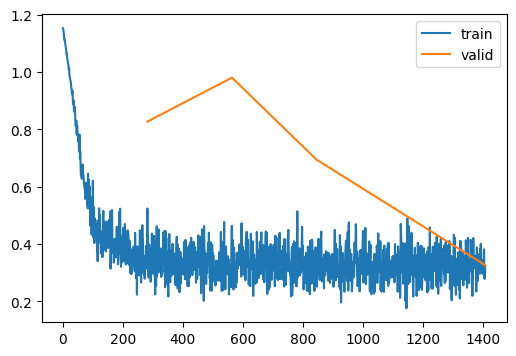

CPU times: total: 50min 15s
Wall time: 6min 28s


In [133]:
%%time

learn.fit(epochs)

### ----------------------------------------

### Activation Stats

In [134]:
def show_act_stats(act_stats, n_chart= 10):

    act_stats.plot_stats(figsize= figsize_stats, n_chart= n_chart)
    # act_stats.color_dim(figsize= figsize_cld, n_chart= n_chart)
    act_stats.color_dim_zoom(figsize= figsize_cldz, n_chart= n_chart)
    act_stats.dead_chart(figsize= figsize_dead, n_chart= n_chart)

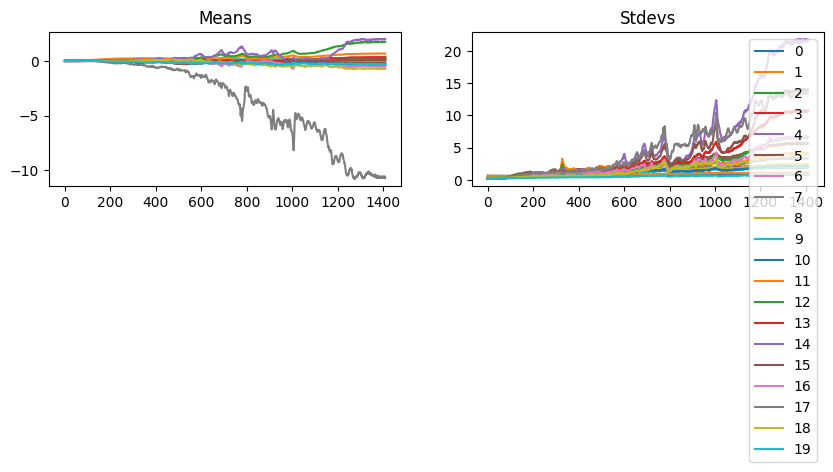

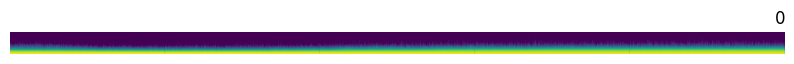

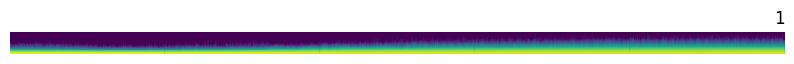

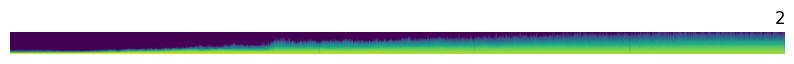

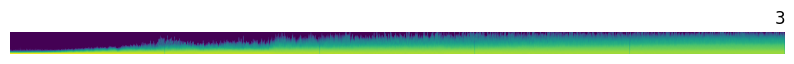

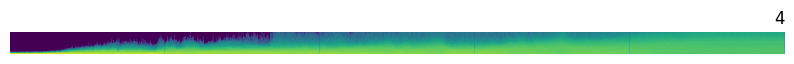

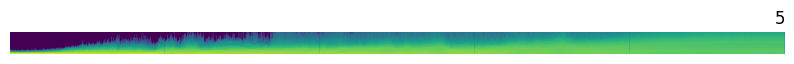

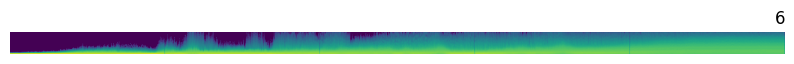

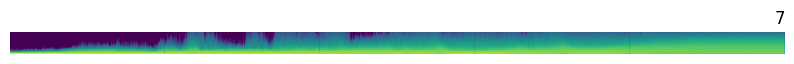

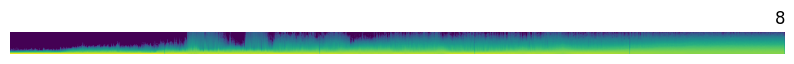

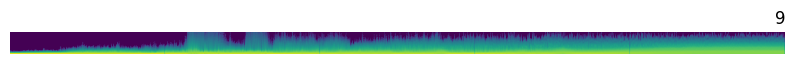

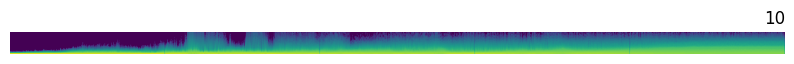

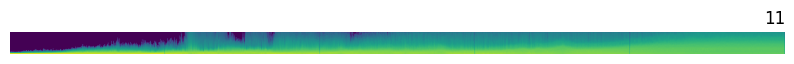

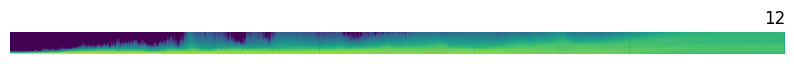

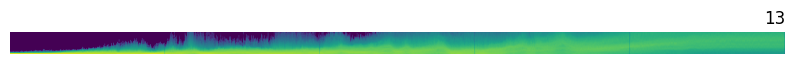

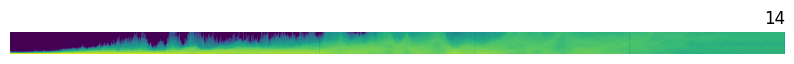

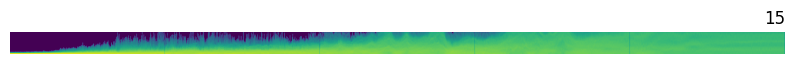

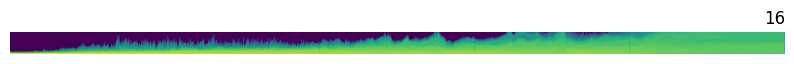

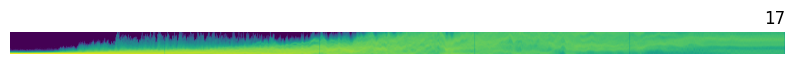

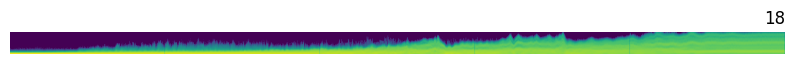

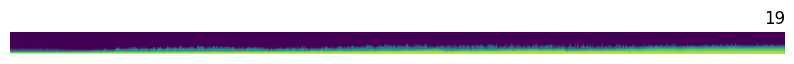

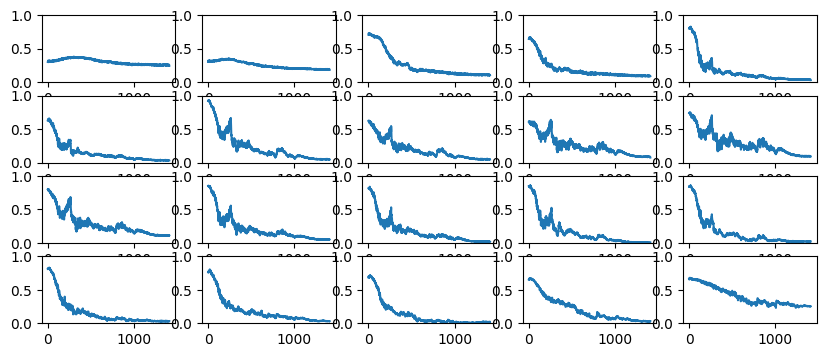

In [135]:
show_act_stats(act_stats, n_chart= 20)

### ----------------------------------------

In [136]:
model

UNet2DModel(
  (conv_in): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
 